# Convolutional Neural Network (CNN)

## Data Preprocessing
I will use the function "extract_mel_spectrogram" to extract the data from the cleaned csv file. Before constructing the model though, a few additional steps have to be taken:
1. Values of the mel spectrograms should be scaled so that they are between 0 and 1 for computational efficiency.
2. The data is currently 7994 rows of mel spectrograms that are 128 x 660. We need to reshape this to be 7994 rows of 128 x 660 x 1 to represent that there is a single color channel. If our image had three color channels, RGB, we would need this additional dimension to be 3. 
3. Target values have to be one-hot-encoded in order to be fed into a neural network.

In [1]:
# Imports
import os
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.utils import to_categorical

/home/gatzoniskon/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [47]:
# Option to drop certain features
drop_genres = True
genres_to_be_dropped = [5,6]

new_label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    7: 4,
    8: 5
}

# Extract Spectrograms from CSV
def extract_mel_spectrogram(directory):
    df = pd.read_csv(directory+'genre_mel_specs_clean.csv')
    if(drop_genres == True):
        for g in genres_to_be_dropped:
            df = df[df.y != g]
        df['y'] = df['y'].map(new_label_map)

    y = df['y']
    X = df.drop(labels = 'y', axis = 'columns')
    # Returning the mel spectrograms and labels
    return X, y

In [48]:
# Using the function to read and extract mel spectrograms from the FMA Dataset csv files
X, y = extract_mel_spectrogram('../fma_data/')

In [63]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y, test_size=.2)

**Note:** It is important that we train test split before scaling and reshaping the data to avoid data leakage.

In [50]:
# Checking the minimum value (the scale ranges from zero to some negative value) to see how we should scale the data
X_train.min()

0       -80.0
1       -80.0
2       -80.0
3       -80.0
4       -80.0
         ... 
84475     0.0
84476     0.0
84477     0.0
84478     0.0
84479     0.0
Length: 84480, dtype: float64

In [64]:
# Scaling our data to be between 0 and 1 using the minimum value from above
X_train /= -80
X_test /= -80

In [65]:
# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

In [66]:
# Ensure labels are ndarrays with values from 0 to 7
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

if (max(y_train) > 7):
    y_train = np.subtract(y_train, max(y_train)-7)
    
if (max(y_test) > 7):
    y_test = np.subtract(y_test, max(y_test)-7)

In [67]:
print(min(y_train))
print(max(y_train))
classes = max(y_train)-min(y_train)+1
print(classes)

0
5
6


In [68]:
y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

## Constructing a CNN

In [74]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

# Initialize Optimizer
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)

# Initializing a random seed for replication purposes
np.random.seed(23456)
tf.random.set_seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer (CHANGED TO 8 OUTPUTS)
cnn_model.add(Dense(classes, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=5)

Epoch 1/5
300/300 [==============================] - 42s 138ms/step - loss: 1.8160 - accuracy: 0.1972 - val_loss: 1.4859 - val_accuracy: 0.4112
Epoch 2/5
300/300 [==============================] - 41s 137ms/step - loss: 1.4748 - accuracy: 0.4073 - val_loss: 1.4101 - val_accuracy: 0.4520
Epoch 3/5
300/300 [==============================] - 40s 135ms/step - loss: 1.3496 - accuracy: 0.4773 - val_loss: 1.2813 - val_accuracy: 0.5054
Epoch 4/5
300/300 [==============================] - 41s 135ms/step - loss: 1.2447 - accuracy: 0.5108 - val_loss: 1.2168 - val_accuracy: 0.5521
Epoch 5/5
300/300 [==============================] - 41s 136ms/step - loss: 1.1722 - accuracy: 0.5433 - val_loss: 1.1888 - val_accuracy: 0.5613


In [75]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 40, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2457664   
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0     

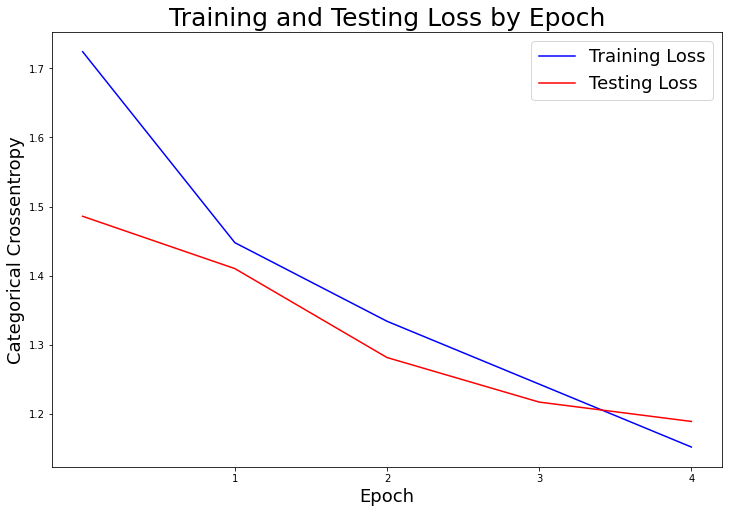

In [76]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,5), range(1,5))

plt.legend(fontsize = 18);

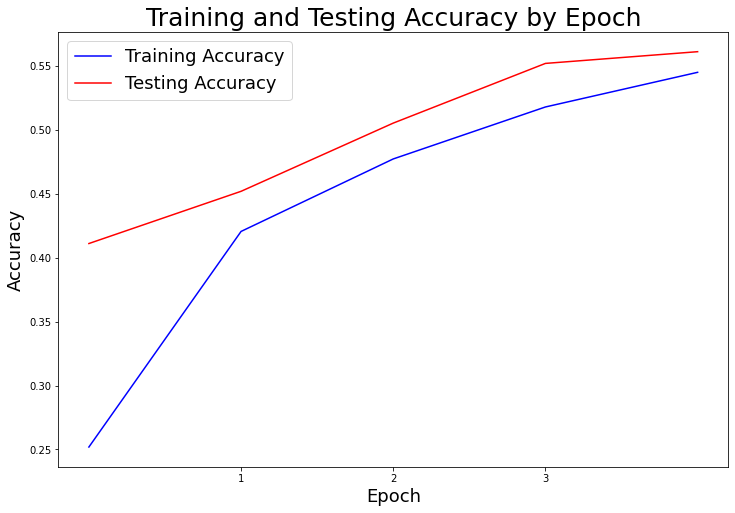

In [77]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,4), range(1,4))

plt.legend(fontsize = 18);

In [78]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=1)

38/38 [==============================] - 3s 73ms/step


### Confusion Matrix
To look deeper into what was happening with the model, I computed a confusion matrix to visualize the model's predictions against the actual values.

**Note:** since the confusion matrix function from sklearn does not return the labels for predicted values and actual values, I checked how many predicted and actual values there were for each genre to be able to figure it out.

In [79]:
# Checking the number of targets per class
for i in range(classes): 
    print(f'{i}: {sum([1 for target in y_test if target[i] == 1])}')

0: 200
1: 200
2: 200
3: 199
4: 200
5: 200


In [82]:
# Checking the number of predicted values in each class
for i in range(classes): 
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0: 120
1: 245
2: 203
3: 298
4: 87
5: 246


In [83]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[ 59,  23,   7,  72,  22,  17],
       [ 12, 130,  15,  14,  10,  19],
       [  2,  36, 137,   7,   7,  11],
       [ 22,   6,   2, 160,   3,   6],
       [ 22,  29,  33,  38,  36,  42],
       [  3,  21,   9,   7,   9, 151]])

In [84]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5
0,59,23,7,72,22,17
1,12,130,15,14,10,19
2,2,36,137,7,7,11
3,22,6,2,160,3,6
4,22,29,33,38,36,42
5,3,21,9,7,9,151


In [85]:
# Creating a dictionary of labels
labels_dict = {
    0: 'Electronic',
    1: 'Experimental',
    2: 'Folk',
    3: 'Hip-Hop',
    4: 'Instrumental',
    5: 'International',
    6: 'Pop',
    7: 'Rock'
}
if (drop_genres == True):
    lebels_dict = new_label_map

In [86]:
# Renaming rows and columns with labes
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International
Electronic,59,23,7,72,22,17
Experimental,12,130,15,14,10,19
Folk,2,36,137,7,7,11
Hip-Hop,22,6,2,160,3,6
Instrumental,22,29,33,38,36,42
International,3,21,9,7,9,151


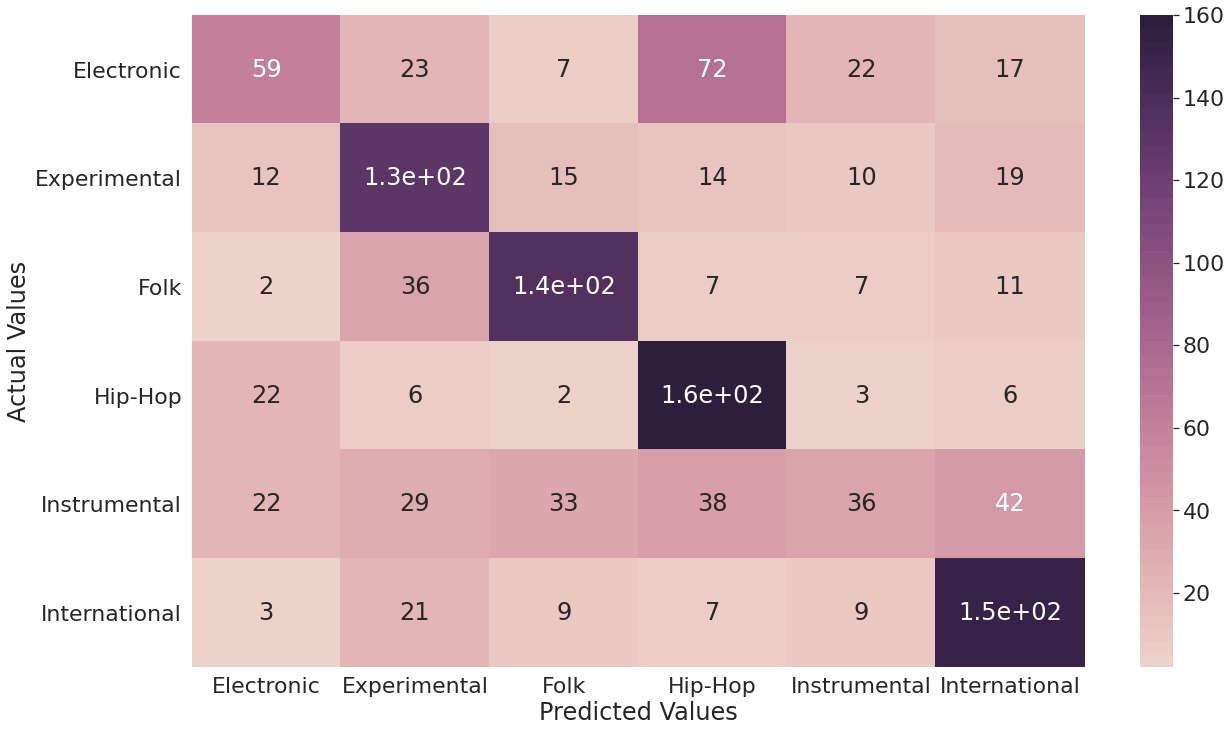

In [87]:
# Creating a heatmap for the confusion matrix for display
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True, cmap=sns.cubehelix_palette(50));
ax.set(xlabel='Predicted Values', ylabel='Actual Values');